### Veamos algunos ejemplos de los datos (imagenes de numeros) que tenemos 

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

Modalidades detectadas: ['m0', 'm1', 'm2', 'm3', 'm4']


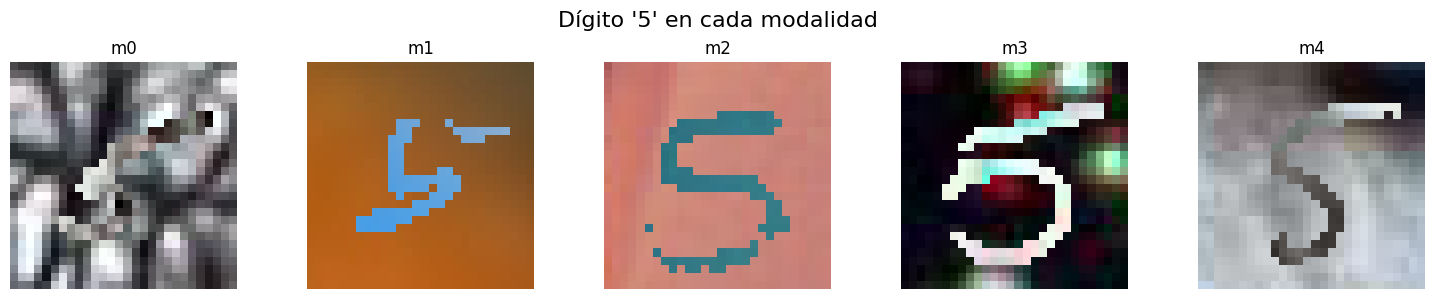

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Definir carpeta base (desde donde se ejecuta el notebook)
base_dir = "train"

# Detectar automáticamente todas las modalidades m0, m1, ..., m4
modalities = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
])

print("Modalidades detectadas:", modalities)

# Elegir qué dígito mostrar (0 al 9)
target_label = "5"  

images = []

# Recorrer cada modalidad
for mod in modalities:
    folder_path = os.path.join(base_dir, mod)

    # Filtrar imágenes con la etiqueta deseada 
    all_images = [
        f for f in os.listdir(folder_path)
        if f.endswith(".png") and f.split(".")[1] == target_label
    ]

    if not all_images:
        print(f"No se encontraron imágenes con etiqueta {target_label} en {mod}")
        continue

    # Elegir una imagen aleatoria de esa etiqueta
    img_file = random.choice(all_images)
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    images.append((mod, img))

# Mostrar las imágenes seleccionadas
plt.figure(figsize=(15, 3))
for idx, (mod, img) in enumerate(images):
    plt.subplot(1, len(images), idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{mod}")
    plt.axis("off")

plt.suptitle(f"Dígito '{target_label}' en cada modalidad", fontsize=16)
plt.tight_layout()
plt.show()

### 2. Análisis exploratorio

,m0,m1,m2,m3,m4
0,5923,5923,5923,5923,5923
1,6742,6742,6742,6742,6742
2,5958,5958,5958,5958,5958
3,6131,6131,6131,6131,6131
4,5842,5842,5842,5842,5842
5,5421,5421,5421,5421,5421
6,5918,5918,5918,5918,5918
7,6265,6265,6265,6265,6265
8,5851,5851,5851,5851,5851
9,5949,5949,5949,5949,5949


<Figure size 1200x600 with 0 Axes>

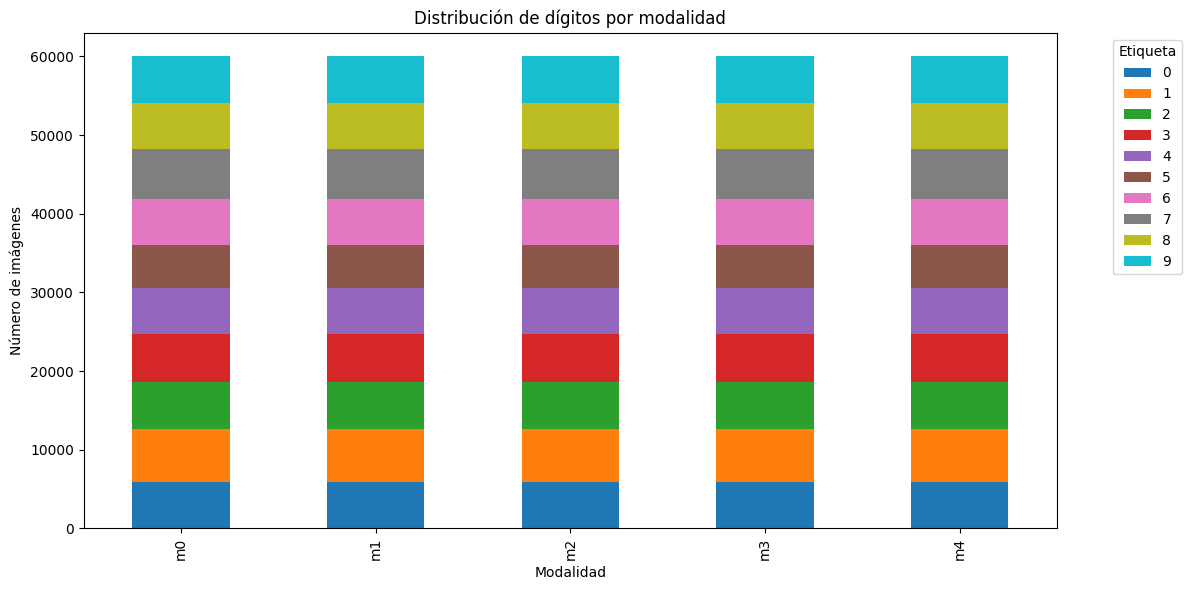

Resoluciones detectadas: {(28, 28)}


In [16]:
import os
from collections import defaultdict, Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Base path donde están tus datos
base_dir = "./train"

# Detectar modalidades m0, m1, ...
modalities = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
])

# Contar imágenes por etiqueta en cada modalidad
distribution = defaultdict(Counter)
resolutions = set()

for mod in modalities:
    folder = os.path.join(base_dir, mod)
    for file in os.listdir(folder):
        if file.endswith(".png"):
            label = file.split(".")[1]
            distribution[mod][label] += 1

            # Guardar resolución (tamaño) de una imagen
            img_path = os.path.join(folder, file)
            with Image.open(img_path) as img:
                resolutions.add(img.size)

# Mostrar tabla
df = pd.DataFrame(distribution).fillna(0).astype(int).sort_index()
display(df)

# Mostrar gráfico
plt.figure(figsize=(12, 6))
df.T.plot(kind="bar", stacked=True, colormap="tab10", figsize=(12,6))
plt.title("Distribución de dígitos por modalidad")
plt.xlabel("Modalidad")
plt.ylabel("Número de imágenes")
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Ver resoluciones únicas
print("Resoluciones detectadas:", resolutions)


El conjunto de datos está organizado en 5 modalidades (m0 a m4). Se realizó un análisis de distribución de etiquetas y se encontró que cada modalidad contiene un número equilibrado de imágenes por clase (0–9), lo que indica que el dataset está balanceado. Además, todas las imágenes tienen una resolución uniforme de 28×28 píxeles.

,m0,m1,m2,m3,m4
train,60000,60000,60000,60000,60000
test,10000,10000,10000,10000,10000


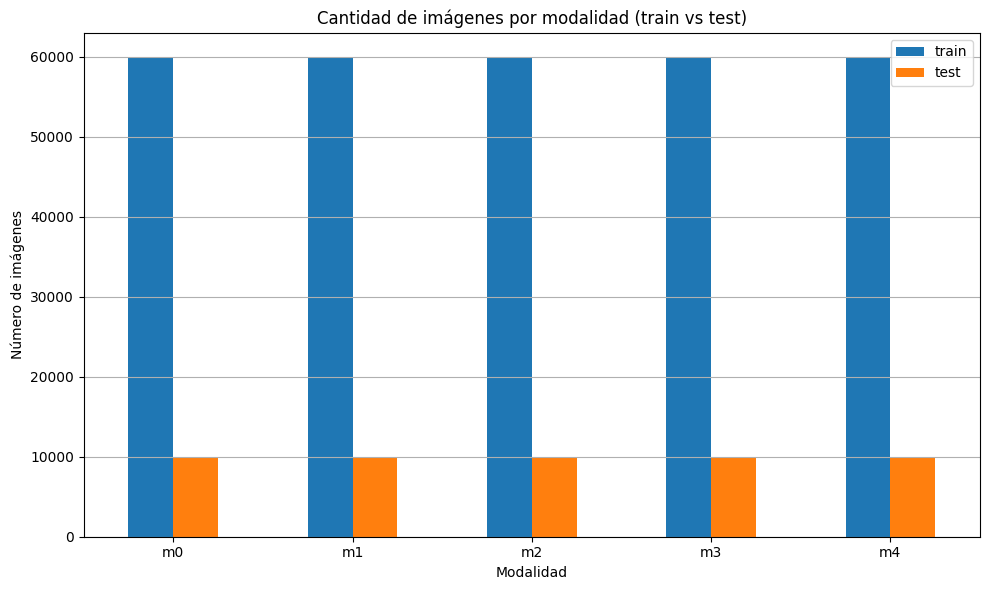

In [15]:
import os
from collections import defaultdict

# Directorios principales
root_dirs = ["train", "test"]
conteo = defaultdict(lambda: defaultdict(int))

for root in root_dirs:
    base_dir = f"./{root}"
    modalities = sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
    ])
    
    for mod in modalities:
        folder_path = os.path.join(base_dir, mod)
        num_imgs = len([f for f in os.listdir(folder_path) if f.endswith(".png")])
        conteo[root][mod] = num_imgs

# Mostrar tabla
import pandas as pd
df_conteo = pd.DataFrame(conteo).T
display(df_conteo)

# Gráfico
import matplotlib.pyplot as plt
df_conteo.T.plot(kind="bar", figsize=(10,6))
plt.title("Cantidad de imágenes por modalidad (train vs test)")
plt.xlabel("Modalidad")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Modelos

Modelo 1

In [21]:
import os
import numpy as np
from PIL import Image

def cargar_modalidad(ruta_modalidad, tamaño=(28, 28)):
    X = []
    y = []

    for archivo in os.listdir(ruta_modalidad):
        if archivo.endswith(".png"):
            etiqueta = int(archivo.split(".")[1])
            ruta_img = os.path.join(ruta_modalidad, archivo)
            img = Image.open(ruta_img).resize(tamaño)
            arr = np.array(img).astype(np.float32) / 255.0
            X.append(arr)
            y.append(etiqueta)
    
    return np.array(X), np.array(y)

# Ruta base
data_dir = "train"

x_train = []
y_train = []

# Cargar solo modalidad m0
print("Cargando solo m0 para pruebas...")
ruta = os.path.join("train", "m0")
x_train, y_train = cargar_modalidad(ruta)

ruta_test = os.path.join("test", "m0")
x_test, y_test = cargar_modalidad(ruta_test)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)



Cargando solo m0 para pruebas...
x_train: (60000, 28, 28, 3)
y_train: (60000,)
x_test: (10000, 28, 28, 3)
y_test: (10000,)


In [22]:
ruta = os.path.join("train", "m0")
x_train, y_train = cargar_modalidad(ruta)

ruta_test = os.path.join("test", "m0")
x_test, y_test = cargar_modalidad(ruta_test)

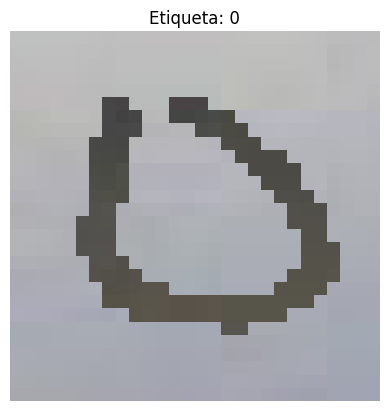

In [24]:

# Mostrar imagen y etiqueta
idx = 4200
plt.imshow(x_train[idx])
plt.title(f"Etiqueta: {y_train[idx]}")
plt.axis('off')
plt.show()


In [27]:
# Normalizacion 
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


In [29]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [30]:
print("x_train:", x_train.shape, x_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("Ejemplo etiqueta codificada:", y_train[0])

x_train: (60000, 28, 28, 3) float32
y_train: (60000, 10, 10) float64
Ejemplo etiqueta codificada: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Arquitectura CNN

In [ ]:
# Definición del modelo
model = models.Sequential()

# Capa 1: Conv2D
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))

# Capa 2: Conv2D
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

# Capa 3: MaxPooling2D
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Capa 4: Conv2D
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

# Capa 5: Conv2D
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

# Capa 6: MaxPooling2D
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Capa 7: Conv2D
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

# Capa 8: Conv2D
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

# Capa 9: MaxPooling2D
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Capa 10: Flatten
model.add(layers.Flatten())

# Capa 11: Dense
model.add(layers.Dense(128, activation='relu'))

# Capa 12: Dense final (10 clases)
model.add(layers.Dense(10, activation='softmax'))

# Compilación
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Corregir doble one-hot encoding
if y_train.ndim == 3 and y_train.shape[1:] == (10, 10):
    y_train = np.array([np.argmax(y) for y in y_train])
    y_train = to_categorical(y_train, 10)

if y_test.ndim == 3 and y_test.shape[1:] == (10, 10):
    y_test = np.array([np.argmax(y) for y in y_test])
    y_test = to_categorical(y_test, 10)

In [38]:
# Verifica y corrige si está doblemente codificado
def corregir_labels(y):
    if isinstance(y, list):
        y = np.array(y)

    if y.ndim == 3 and y.shape[1:] == (10, 10):
        # Doble one-hot: volver a enteros
        y = np.array([np.argmax(row) for row in y])
        y = to_categorical(y, 10)
    elif y.ndim == 2 and y.shape[1] != 10:
        # Asegurar que sea categórico
        y = to_categorical(y, 10)
    elif y.ndim == 1:
        y = to_categorical(y, 10)
    
    return y

y_train = corregir_labels(y_train)
y_test = corregir_labels(y_test)

print("y_train.shape:", y_train.shape)
print("Ejemplo de etiqueta:", y_train[0])


y_train.shape: (60000, 10)
Ejemplo de etiqueta: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [39]:
print(x_train.shape)  # Debe ser (60000, 28, 28, 3)
print(y_train.shape)  # Debe ser (60000, 10)

(60000, 28, 28, 3)
(60000, 10)


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # <- salida para 10 clases
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8912 - loss: 0.4706 - val_accuracy: 0.9064 - val_loss: 0.3151
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9006 - loss: 0.3153 - val_accuracy: 0.9171 - val_loss: 0.2171
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9203 - loss: 0.2131 - val_accuracy: 0.9453 - val_loss: 0.1555
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9456 - loss: 0.1534 - val_accuracy: 0.9578 - val_loss: 0.1245
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9568 - loss: 0.1210 - val_accuracy: 0.9633 - val_loss: 0.1018
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9646 - loss: 0.0992 - val_accuracy: 0.9689 - val_loss: 0.0891
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9689 - loss: 0.0871 - val_accuracy: 0.9716 - val_loss: 0.0797
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9731 - loss: 0.0765 - 

In [42]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9829 - loss: 0.0497
Precisión en test: 0.9818


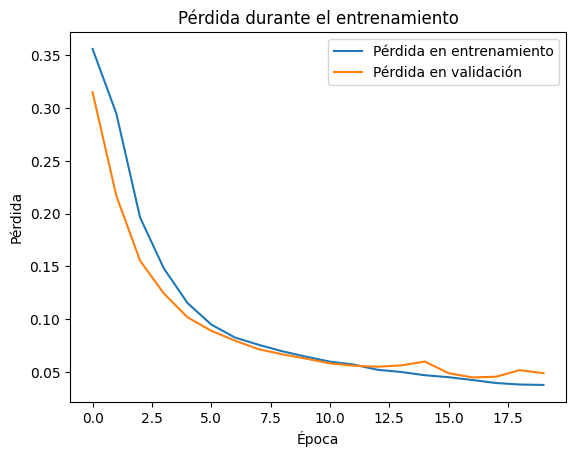

In [43]:
# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

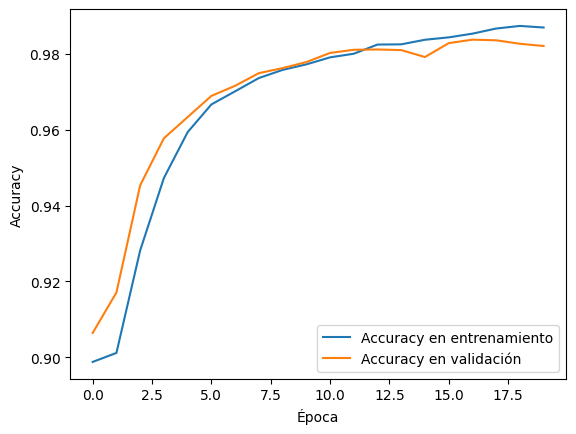

In [44]:
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Se entrenó una red neuronal convolucional (CNN) con una capa Conv2D y MaxPooling2D, seguida por capas densas. Se usó categorical_crossentropy como función de pérdida y adam como optimizador.

El modelo alcanzó una precisión de 98.18% en el conjunto de prueba, lo que indica un excelente rendimiento. Las curvas de pérdida muestran una mejora constante sin sobreajuste, con la pérdida de validación disminuyendo en paralelo a la de entrenamiento.

Modelo 2

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)),
    Conv2D(64, (3,3), activation='relu'),        # Nueva capa
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),       # Nueva capa más profunda
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256, activation='relu'),               # Más unidades
    Dropout(0.5),                                # Regularización para evitar overfitting
    Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history2 = model2.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.8922 - loss: 0.4377 - val_accuracy: 0.9064 - val_loss: 0.3112
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 76s 102ms/step - accuracy: 0.8995 - loss: 0.3318 - val_accuracy: 0.9064 - val_loss: 0.3125
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/step - accuracy: 0.8990 - loss: 0.3334 - val_accuracy: 0.9064 - val_loss: 0.3119
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 89ms/step - accuracy: 0.8963 - loss: 0.3368 - val_accuracy: 0.9064 - val_loss: 0.3163
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 84ms/step - accuracy: 0.9018 - loss: 0.3261 - val_accuracy: 0.9064 - val_loss: 0.3112
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.9006 - loss: 0.3277 - val_accuracy: 0.9064 - val_loss: 0.3144
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.8996 - loss: 0.3290 - val_accuracy: 0.9064 - val_loss: 0.3108
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.8999 - loss: 0.3283 

In [46]:
test_loss2, test_acc2 = model2.evaluate(x_test, y_test)
print(f"Precisión en test (modelo 2): {test_acc2:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9085 - loss: 0.3059
Precisión en test (modelo 2): 0.9020


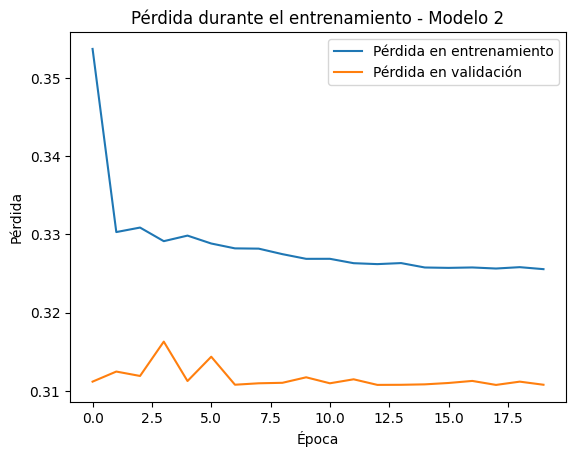

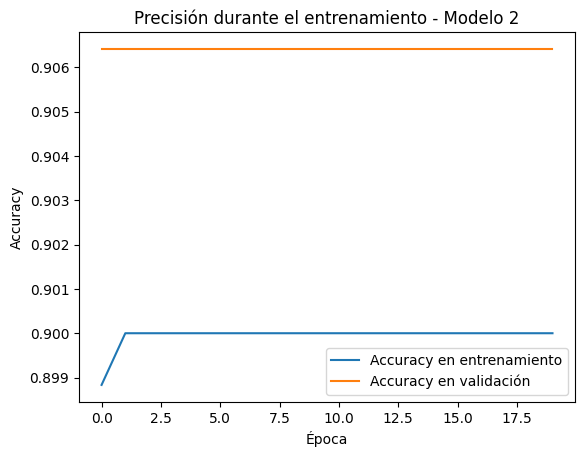

In [47]:
# Pérdida
plt.plot(history2.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento - Modelo 2')
plt.show()

# Accuracy
plt.plot(history2.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Accuracy en validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión durante el entrenamiento - Modelo 2')
plt.show()
